# AirBnB Listings in Los Angeles, CA
##### Data source: http://insideairbnb.com/get-the-data.html
##### Date compiled: May 8, 2020
## 2 - Exploratory Data Analysis

### Dependencies

In [1]:
from os import path
from datetime import datetime

from scipy import stats
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from utils import utils, plotting

%matplotlib inline

In [2]:
# Settings
pd.options.display.max_columns = 200
pd.options.display.max_rows = 50000
sns.set()
px.set_mapbox_access_token(utils.get_token())

### Data

In [3]:
reviews = pd.read_csv('data/reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304141 entries, 0 to 1304140
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1304141 non-null  int64 
 1   id             1304141 non-null  int64 
 2   date           1304141 non-null  object
 3   reviewer_id    1304141 non-null  int64 
 4   reviewer_name  1304139 non-null  object
 5   comments       1303081 non-null  object
dtypes: int64(3), object(3)
memory usage: 59.7+ MB


In [4]:
listings = pd.read_pickle('data/listings_clean.pkl')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37028 entries, 0 to 37047
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                37028 non-null  int64         
 1   host_is_superhost                 37028 non-null  float64       
 2   neighbourhood_cleansed            37028 non-null  object        
 3   zipcode                           37028 non-null  object        
 4   latitude                          37028 non-null  float64       
 5   longitude                         37028 non-null  float64       
 6   property_type                     37028 non-null  object        
 7   room_type                         37028 non-null  object        
 8   accommodates                      37028 non-null  int64         
 9   bathrooms                         37028 non-null  float64       
 10  bedrooms                          37028 non-nu

### Rename and recast columns

In [5]:
# Rename columns to simpler names
listings.rename(columns={'host_is_superhost': 'by_superhost',
                         'neighbourhood_cleansed': 'neighborhood',
                         'review_scores_rating': 'score_rtg',
                         'review_scores_accuracy': 'score_accu',
                         'review_scores_cleanliness': 'score_clean',
                         'review_scores_checkin': 'score_check',
                         'review_scores_communication': 'score_comm',
                         'review_scores_location': 'score_loc',
                         'review_scores_value': 'score_val'}, inplace=True)

# Cast `by_superhost` as integer type
listings['by_superhost'] = listings.by_superhost.astype(int)
listings.head(2)

,id,by_superhost,neighborhood,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,score_rtg,score_accu,score_clean,score_check,score_comm,score_loc,score_val,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,109,0,Culver City,90230,33.98209,-118.38494,Condominium,Entire home/apt,6,2.0,2.0,3.0,122.0,500.0,240.0,3,25.0,30,0,0,0,38,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,0,strict_14_with_grace_period,1,0,0.02
1,344,0,Burbank,91505,34.16562,-118.33458,House,Entire home/apt,6,1.0,3.0,3.0,168.0,0.0,100.0,6,0.0,15,0,1,6,97,8,2,2016-06-14,2019-10-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,0.17


### Filter out listings with an outlier price

In [6]:
list765 = listings[listings.price <= 765].copy()
list765.describe()

,id,by_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,score_rtg,score_accu,score_clean,score_check,score_comm,score_loc,score_val,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
count,3.556300e+04,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,35563.000000,28295.000000,28248.000000,28249.000000,28238.000000,28247.000000,28234.000000,28230.000000,35563.000000,35563.000000,35563.000000,35563.000000
mean,2.505182e+07,0.328797,34.050258,-118.313326,3.442032,1.371439,1.344740,1.862947,140.761016,269.070410,76.392655,1.848466,14.443916,15.482833,14.973849,32.450384,50.488120,165.779406,36.362371,12.142733,94.269553,9.612928,9.416652,9.748212,9.717386,9.705001,9.432944,0.436015,0.013582,0.021258,1.312094
std,1.280203e+07,0.469783,0.121526,0.163990,2.410231,0.772871,0.972507,1.518274,115.610321,594.610912,79.641091,1.594151,24.709441,11.178341,13.336440,25.868994,38.232703,142.389288,65.212058,18.640812,9.013689,0.887676,1.008461,0.774724,0.827613,0.730063,0.935986,0.495896,0.115747,0.144245,1.707011
min,1.090000e+02,0.000000,33.338830,-118.934220,1.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.498344e+07,0.000000,33.997370,-118.419410,2.000000,1.000000,1.000000,1.000000,68.000000,0.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,93.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.080000
50%,2.612833e+07,0.000000,34.060980,-118.340130,2.000000,1.000000,1.000000,1.000000,100.000000,100.000000,55.000000,1.000000,5.000000,15.000000,17.000000,38.000000,66.000000,147.000000,9.000000,3.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.580000
75%,3.672257e+07,1.000000,34.104125,-118.248790,4.000000,1.500000,2.000000,2.000000,172.000000,300.000000,100.000000,2.000000,20.000000,30.000000,29.000000,59.000000,89.000000,333.000000,42.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000,1.980000
max,4.338380e+07,1.000000,34.811190,-117.652640,24.000000,11.500000,11.000000,50.000000,754.000000,5100.000000,749.000000,24.000000,300.000000,30.000000,30.000000,60.000000,90.000000,365.000000,822.000000,211.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,17.230000


### Is there a difference with listings by superhosts?

,regular_hosts,superhosts
count,23870.000000,11693.000000
mean,139.162673,144.023860
std,117.277288,112.064673
min,10.000000,10.000000
25%,65.000000,75.000000
50%,100.000000,110.000000
75%,170.000000,175.000000
max,752.000000,754.000000


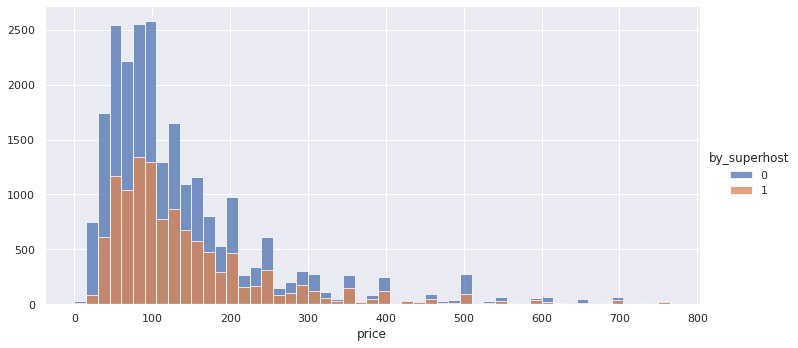

In [7]:
# Price distribution for listings by regular hosts and superhosts
plotting.hist_with_hue(list765, 'price', range(0, 770, 15))

# Descriptive statistics of price
utils.desc_byhost(list765, 'price')

,regular_hosts,superhosts
count,17439.000000,10856.000000
mean,92.211767,97.575166
std,10.673836,3.319286
min,20.000000,20.000000
25%,90.000000,97.000000
50%,95.000000,98.000000
75%,100.000000,100.000000
max,100.000000,100.000000


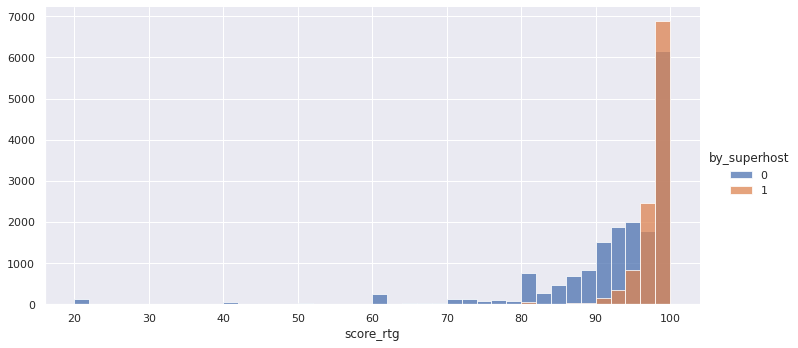

In [8]:
# Rating distribution of listings by regular hosts and superhosts
plotting.hist_with_hue(list765, 'score_rtg', 40)

# Descriptive statistics of rating
utils.desc_byhost(list765, 'score_rtg')

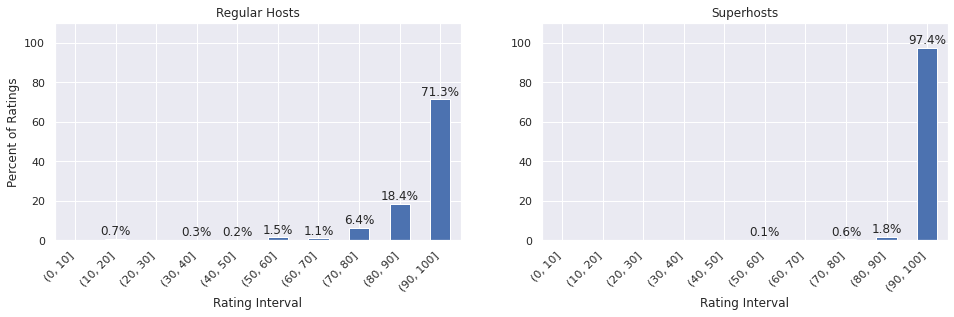

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Rating distribution in relative terms
plotting.hist_pct(list765, ax[0], filter_val=0, title='Regular Hosts', xlab='Rating Interval', ylab='Percent of Ratings')
plotting.hist_pct(list765, ax[1], filter_val=1, title='Superhosts', xlab='Rating Interval')

In [10]:
# 2-sample t-test
reghost = list765[list765.by_superhost == 0].copy()
suphost = list765[list765.by_superhost == 1].copy()
stats.ttest_ind(reghost.score_rtg.dropna(), suphost.score_rtg.dropna(), equal_var=False)

Ttest_indResult(statistic=-61.73398959958312, pvalue=0.0)

***
##### There doesn't seem to be a significant price difference between listings by regular hosts and listings by superhosts. The price distributions of the 2 groups follow a similar shape and the two means fall well within each others' standard deviations.
##### On the other hand, there is a significant difference in user rating with listings by superhosts. This is confirmed with the two-sample t-test performed above which yielded a t-statistic of -61.73. On average, superhost listings are rated 97.6 out of 100 +/- 3.3, compared to 92.2 +/- 10.7. This may not sound like much of a difference, but consider the count comparison in relative terms above. 97.4% of ratings on superhost listings were higher than 90/100, whereas only 71.3% of ratings on listings by regular hosts were higher than 90/100. This means that there is a greater chance of having a good experience if one chooses to stay at a property listed by a superhost. Whether (1) a listing gets better ratings because the host is a superhost or (2) the host became a superhost because they had high ratings is beside the point. The point is simply that superhost listings tend to have higher ratings.
##### The combination of these 2 things is a good sign. From the data, we can see that superhosts are offering a higher chance of a better experience at a similar price point on average.
***

### Are higher ratings associated with higher costs?

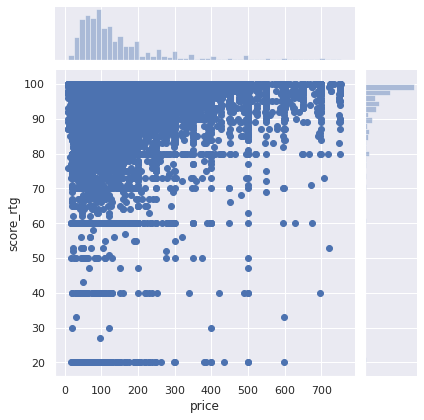

In [11]:
# Price vs overall rating
sns.jointplot(data=list765, x='price', y='score_rtg');

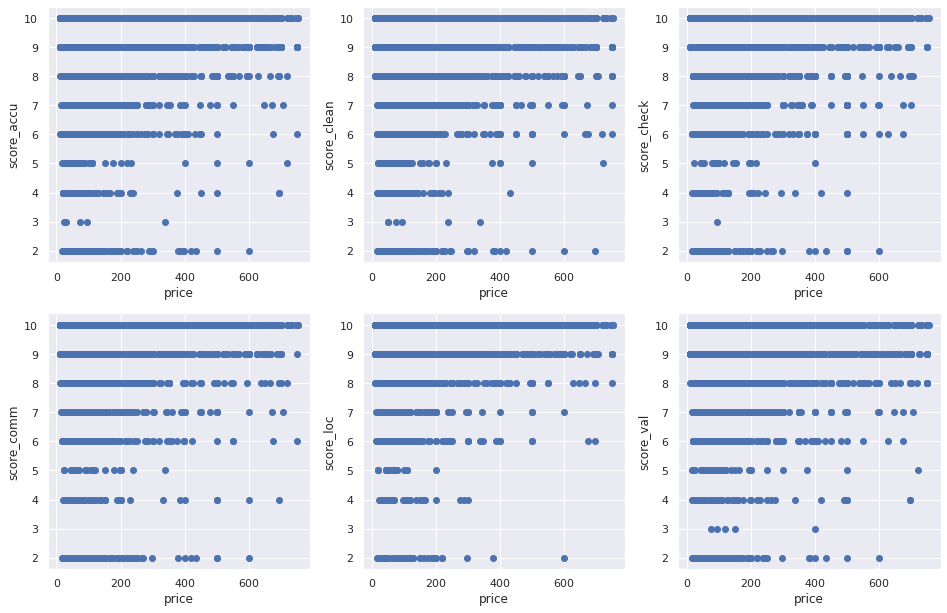

In [12]:
score_vars = ['price', 'score_rtg', 'score_accu', 'score_clean', 'score_check', 'score_comm', 'score_loc', 'score_val']

# Price vs different rating types
plotting.scatter_subplots(list765, score_vars)

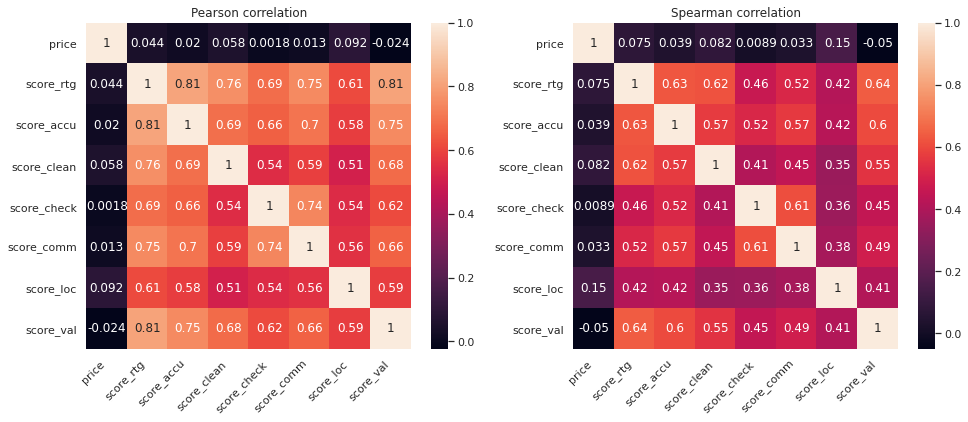

In [13]:
# Correlation
plotting.corr_heatmap(list765, score_vars)

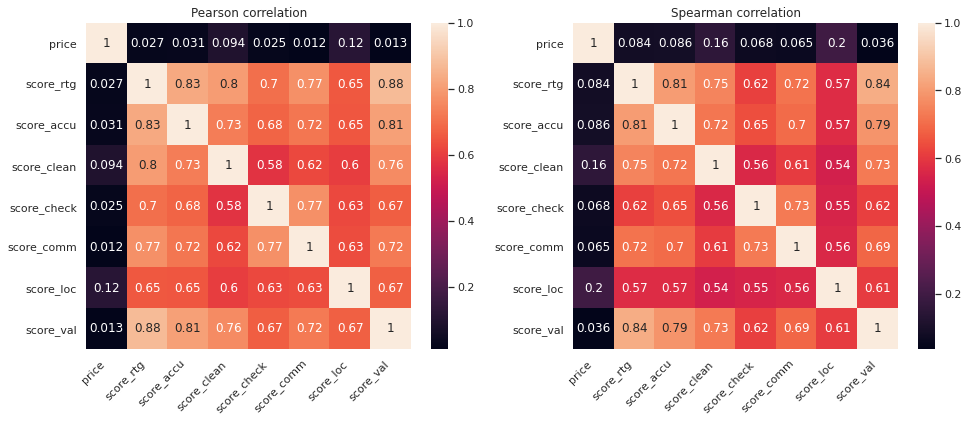

In [14]:
# Downsample high ratings
sub = list765[list765.score_rtg >= 80].copy().sample(500, random_state=0)
samp = pd.concat([list765[list765.score_rtg < 80].copy(), sub])

# Correlation of sample
plotting.corr_heatmap(samp, score_vars)

***
##### The review variables all have a strong linear correlation with each other, which makes sense, but this is not what we are looking for. There is a very weak monotonic correlation between the `price` and the location score, and after downsampling the high ratings, between the `price` and the cleanliness score. But other than that, there is no relationship between rating and price.
***

### What are reviewers saying?

In [47]:
# Extract listings with an overall rating of less than 30
low = list765[list765.score_rtg < 30].id.tolist()
bad = reviews[reviews.listing_id.isin(low)].dropna(subset=['comments'])
len(low), len(bad)

(125, 159)

In [48]:
# Extract listings with an overall rating of 100
high = list765[list765.score_rtg == 100].id.tolist()
good = reviews[reviews.listing_id.isin(high)].dropna(subset=['comments'])
len(high), len(good)

(7775, 96530)

In [49]:
# Aggregate the bad reviews
bad_reviews = ' '.join(bad.comments.tolist())

# Aggregate the good reviews
good_reviews = ' '.join(good.comments.tolist())

# Approximate word count of each
len(bad_reviews.split(' ')), len(good_reviews.split(' '))

(14055, 4729270)

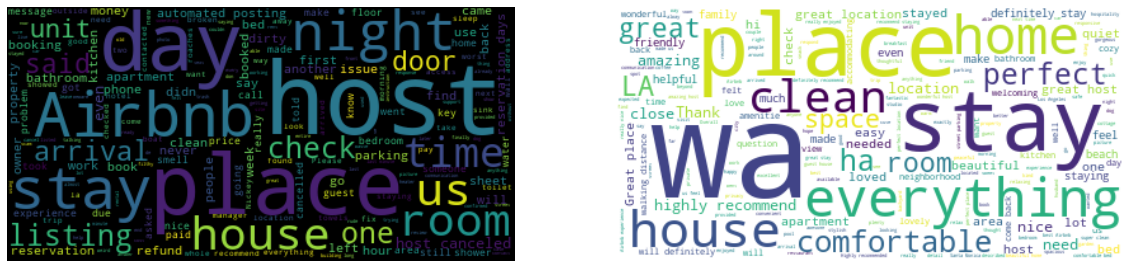

In [50]:
plt.figure(figsize=(20, 10))
# Bad reviews
plt.subplot(1, 2, 1)
plotting.wordcloud(bad_reviews, bg_color='black')

# Good reviews
plt.subplot(1, 2, 2)
plotting.wordcloud(good_reviews)

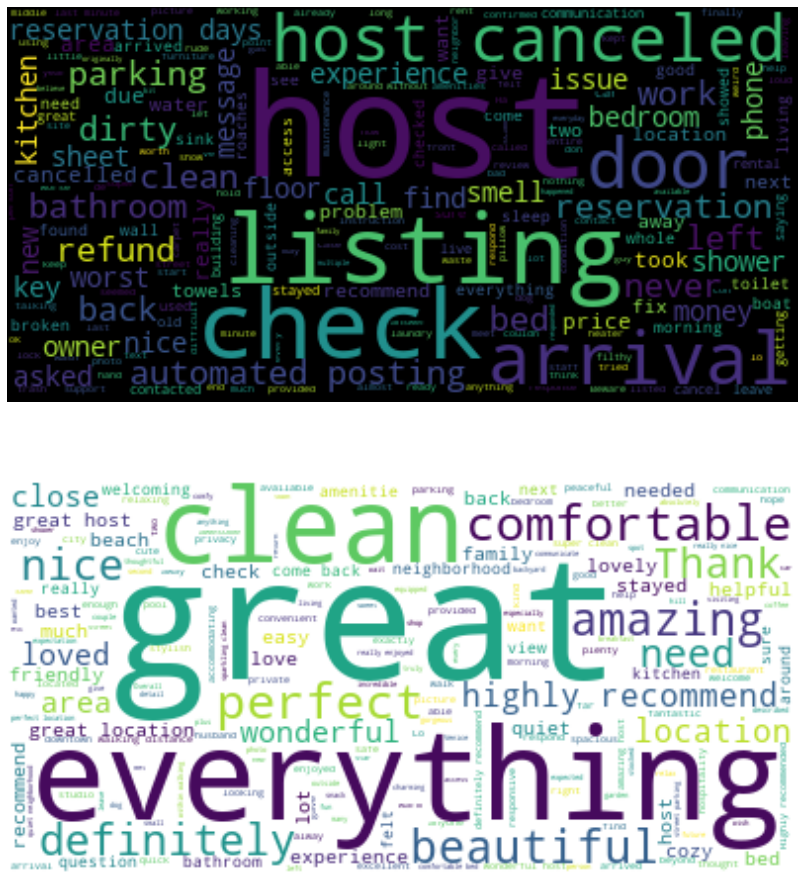

In [51]:
# Stopword list
words = 'place stay Airbnb house apartment home day us booked said know staying something going wa Karla Jane John Ryan \
         ha visit made unit one will even LA trip night didn got went time hour room please property manager Nickey \
         another told week say someone go address thing people first though space hotel paid use book booking still \
         pay later take friend hi Los Angeles Santa Monica cottage feel Hollywood make way well trying look came guest'
stopwords = set(STOPWORDS)
stopwords.update(words.split(' '))

plt.figure(figsize=(16, 16))

# Bad Reviews
plt.subplot(2, 1, 1)
plotting.wordcloud(bad_reviews, bg_color='black', stopwords=stopwords)

# Good Reviews
plt.subplot(2, 1, 2)
plotting.wordcloud(good_reviews, stopwords=stopwords)

***
##### Here, listings with an overall rating of less than 30/100 were collected and their reviews were treated as "bad" reviews. On the other hand, we have listings with an overall rating of 100/100 and their reviews were treated as "good" reviews. In generating a word cloud of good and bad reviews, it was my hope that we would be able to see what users enjoyed the most about their stays versus what users were complaining about the most. We cannot conclude anything based on these word clouds, but they did provide some general insights about good and bad listings.
***